In [1]:
import cv2
import numpy as np
import math
import time
from ultralytics import YOLO
import copy
import matplotlib.pyplot as plt


In [2]:
grocery_model = YOLO(r'/home/bhavesh/pathpal/models/grocery_picking/yolov8x.pt')

def draw_grid(image):
    HEIGHT,WIDTH,CHANNELS = image.shape
    one_third_height = HEIGHT//3
    one_third_width = WIDTH//3
    new_image = np.copy(image)
    cv2.line(new_image,(one_third_width,0),(one_third_width,HEIGHT),(0,0,0),5)
    cv2.line(new_image,(2*one_third_width,0),(2*one_third_width,HEIGHT),(0,0,0),5)
    cv2.line(new_image,(0,one_third_height),(WIDTH,one_third_height),(0,0,0),5)
    cv2.line(new_image,(0,2*one_third_height),(WIDTH,2*one_third_height),(0,0,0),5)
    return new_image

def vibration_matrix(vib_matrix):
    WIDTH, HEIGHT = 400, 400
    one_third_height = HEIGHT//3
    one_third_width = WIDTH//3
     
    output = np.zeros((HEIGHT,WIDTH,3))
    
    for i in range(3):
        for j in range(3):
            startx = one_third_width*i
            endx = startx + one_third_width
            starty = one_third_height*j
            endy = starty + one_third_height
            
            clr = (0,255,0) if vib_matrix[j][i]==0 else (255,0,0)
            cv2.rectangle(output,(startx,starty),(endx,endy),clr,thickness = cv2.FILLED)
            
    output = draw_grid(output)
    
    return output

In [3]:
def draw_bounding_box(img, detected_objects):
    image = img.copy()
    
    for obj in detected_objects:
        class_name = obj['class']
        confidence = obj['confidence']
        x1, y1, x2, y2 = map(int, obj['bounding_box'])
        
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 10)
        
        label = f"{class_name}: {confidence:.2f}"

        # Calculate text size and position
        (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        text_width*=4
        text_height*=4
        cv2.rectangle(image, (x1, y1 - text_height - 10), (x1 + text_width, y1), (255, 0, 0), -1)  # Background for text
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 5)  # Black text
    
    return image, x1, y1, x2, y2
    


0: 640x480 3 bananas, 119.1ms
Speed: 5.2ms preprocess, 119.1ms inference, 184.4ms postprocess per image at shape (1, 3, 640, 480)
3
[{'class': 'banana', 'confidence': 0.7499908208847046, 'bounding_box': [378.4910583496094, 994.5236206054688, 758.4473876953125, 1297.100830078125]}, {'class': 'banana', 'confidence': 0.6628096699714661, 'bounding_box': [28.476104736328125, 619.9332275390625, 817.540771484375, 1182.8753662109375]}, {'class': 'banana', 'confidence': 0.5478981137275696, 'bounding_box': [186.48191833496094, 1009.8057861328125, 459.5906066894531, 1224.8701171875]}]


(-0.5, 1199.5, 1599.5, -0.5)

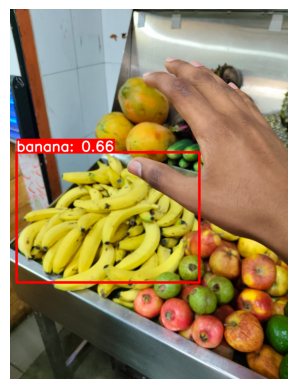

In [4]:
frame = cv2.imread('test_image_4.jpg')

# results = grocery_model.predict(source=frame, save=False, imgsz=640, conf=0.40, show=False, show_labels=True, save_txt=False,classes=[24,39,46,47,49,50,51,73])
results = grocery_model.predict(source=frame, save=False, imgsz=640, conf=0.40, show=False, show_labels=True, save_txt=False,classes=[46])
# backpack bottle banana apple orange broccoli carrot book
temp = copy.deepcopy(frame)

object_centre = 0

# print(results[0].names)
detected_objects = []
for result in results[:1]:
    for box in result.boxes:
        cls = int(box.cls)
        
        # if not grocery_model.names[cls].lower() in target:
        #     continue
        
        conf = box.conf.item()
        xyxy = box.xyxy.flatten().tolist()

        detected_objects.append({
            'class':grocery_model.names[cls],
            'confidence': conf,
            'bounding_box': xyxy
        })
        
        x1, y1, x2, y2 = xyxy
        object_centre = ((x1+x2)//2,(y1+y2)//2)
        
# annotated_image = results[0].plot()
print(len(detected_objects))
# print(results[0])
if detected_objects:
    print(detected_objects)
else:
    print('No grocery detected')

annotated_image, x1f, y1f, x2f, y2f = draw_bounding_box(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), detected_objects[1:2])
plt.imshow(annotated_image)
plt.axis('off')

In [5]:
def get_hand_center(landmarks, image_shape):
    height, width, _ = image_shape
    x_sum, y_sum = 0, 0
    for lm in landmarks:
        x_sum += lm.x
        y_sum += lm.y
    cx = int((x_sum / len(landmarks)) * width)
    cy = int((y_sum / len(landmarks)) * height)
    return (cx, cy)

I0000 00:00:1741468173.603742   22092 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741468173.608277   22264 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.3.4-arch1.1), renderer: Mesa Intel(R) UHD Graphics (ADL-S GT1)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1741468173.637987   22239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741468173.657739   22237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741468173.683820   22245 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


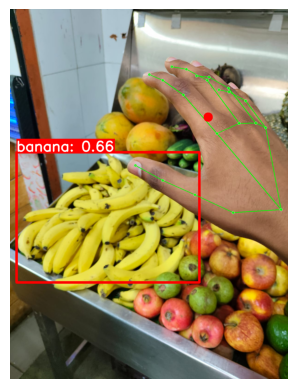

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

# Initialize Mediapipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

result_hands = hands.process(frame_rgb)
frame_rgb = annotated_image.copy()
if result_hands.multi_hand_landmarks:
    for hand_landmarks in result_hands.multi_hand_landmarks[:1]:
        center = get_hand_center(hand_landmarks.landmark, frame_rgb.shape)

        # Draw hand landmarks and connections
        mp_drawing.draw_landmarks(frame_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS, 
                                  mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2))

        # Highlight the center of the hand
        cv2.circle(frame_rgb, center, 20, (255, 0, 0), -1)  # Blue for center

        x2s, y2s = center
        # Relative position between object center and hand center
        if object_centre:
            xob, yob = object_centre
            xhand, yhand = center
            xrel = xob - xhand
            yrel = yob - yhand
            
            h, w = 100, 100
            xvib, yvib = 0, 0

            if xrel > w / 2:
                xvib = 2
            elif xrel > -w / 2:
                xvib = 1

            if yrel > h / 2:
                yvib = 2
            elif yrel > -h / 2:
                yvib = 1

            vib = [[0 for _ in range(3)] for _ in range(3)]
            vib[yvib][xvib] = 1
            vib_output = vibration_matrix(vib)

plt.imshow(frame_rgb)
plt.axis('off')
plt.show()


855 467 422.5 900.5


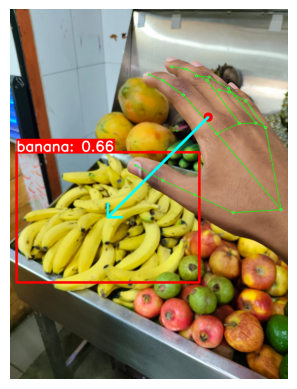

In [7]:
out = frame_rgb.copy()
x1 = (x1f+x2f)/2
y1 = (y1f+y2f)/2
print(x2s, y2s, x1, y1)
cv2.arrowedLine(out, 
                (int(x2s), int(y2s)),  # End point
                (int(x1), int(y1)),  # Start point
                (0, 255, 255),  # Blue color
                10,  # Thickness
                tipLength=0.1)  # Size of the arrowhead

plt.imshow(out)
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


(-0.5, 399.5, 399.5, -0.5)

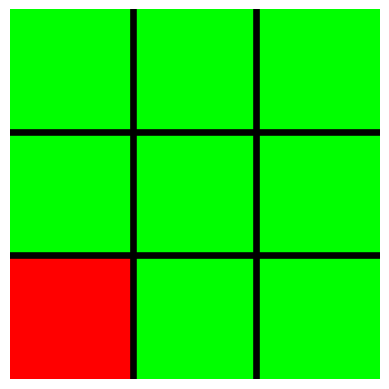

In [8]:
plt.imshow(vib_output)
plt.axis('off')